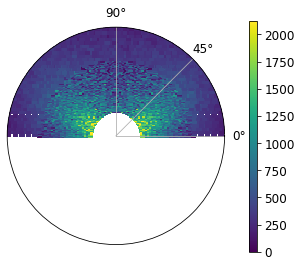

Figure 1: 2D plot of the calculated data


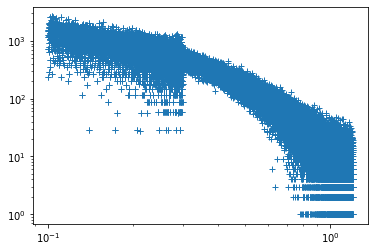

Figure 2: 1D plot of the calculated data


In [3]:
# A fast iterative algorithm (i.e. the so-called Kaczmarz algorithm) is introduced to extract 
# the underlying two-dimensional (2D) correlation function (pair distance distribution function)
# from 2D scattering patterns (SAXS or SANS).
# Here, we analyzed the magnetic SANS pattern of Nanoperm measured at a field strength of 163 mT. 
# Details regarding the experiment can be found in: A. Michels et al., Phys. Rev. B 2006, 74, 134407.

# The results of our analysis of the 2D patterns using the Kaczmarz algorithm are published in:
# P. Bender and J. Leliaert et al., "Imaging nanostructured spin textures"
# https://arxiv.org/abs/2003.14003

#==============================================================================
# Import of used packages

import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import colors
from itertools import groupby
from IPython.display import clear_output

#==============================================================================
# import of data
tvec1,qvec1,Im1= np.genfromtxt('../data/Nanoperm-2DSANS_data.txt',unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2))

Nk=2 # only every Nk's data point is kept. Use integer > 1 when a memory error occurs during Kaczmarz fit
    
tvec=tvec1[1::Nk]
qvec=qvec1[1::Nk]
Im=Im1[1::Nk]

Nq=len(Im)

#==============================================================================
# Plot of calculated data 

s1=15 # symbol size in polar plots
logNorm=colors.LogNorm()

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
plt.thetagrids([0,45,90],fontsize=12)
c = ax.scatter(tvec, qvec, c=Im, s=s1,  marker='s', vmin=0., vmax=0.8*max(Im), cmap='viridis',alpha=1)
ax.set_rscale('linear')
ax.set_rticks([])
ax.set_rlim((0., 0.42))
cbaxes = fig.add_axes([0.82, 0.1, 0.02, 0.8]) 
cbar=plt.colorbar(c,orientation='vertical',norm=logNorm,cax=cbaxes)
cbar.ax.tick_params(labelsize=12)
plt.show()
print('Figure 1: 2D plot of the calculated data')

plt.plot(qvec,Im,'+')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Figure 2: 1D plot of the calculated data')

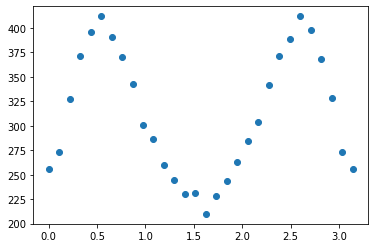

Figure 3: 1D plot of scattering intensity as a function of the angle theta


In [6]:
# 1D plot of the theta dependency of the 2D scattering pattern
# angular binning

Ntint=30
tint=np.linspace(0,np.pi,Ntint)
Dtint=1.*np.pi/(Ntint-1)

Imint=np.zeros(Ntint)
NindList=[]

List1=[]

for i in range(len(qvec)):
    Nind=abs(int(round(tvec[i]/Dtint)))
    NindList.append(Nind)
    Imint[Nind]=Imint[Nind]+Im[i]
    
    List1.append([Nind,Im[i]])
        
List1.sort()
List2=np.asarray(List1)
NindList.sort()          
Number=[len(list(group)) for key, group in groupby(NindList)] 
Number=np.asarray(Number) 
Imint=np.asarray(Imint)
Imint=Imint/Number

plt.plot(tint,Imint,'o')
plt.show()
print('Figure 3: 1D plot of scattering intensity as a function of the angle theta')

Progress of Kaczmarz iteration:
100.0 %


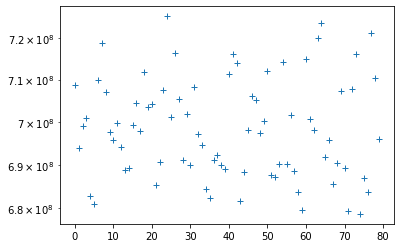

Figure 4: The total error as a function of the number of iteration step


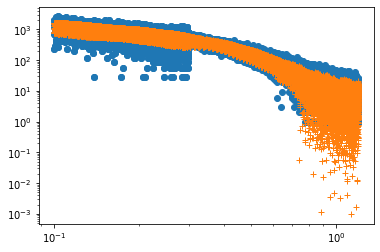

Figure 5: 1D plot of the scattering intensity and the fit via Kaczmarz


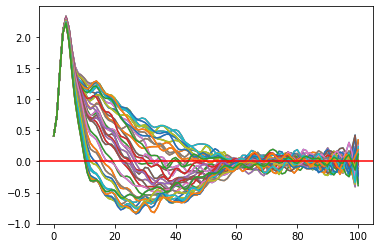

Figure 6: 1D plot of extracted pair distance distribution function


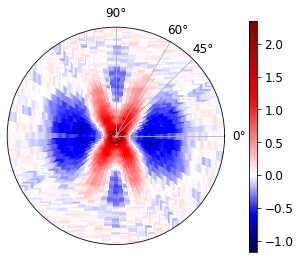

Figure 7: 2D plot of extracted pair distance distribution function


In [5]:
# Kaczmarz fit

print('Progress of Kaczmarz iteration:')
print('0 % (construction of large matrices before Kaczmarz iteration takes some time)')

Nr=101 # number of r values in P(r) distributions (for a given phi)
Nphi=73 # number of chi values for which P(r) is determined 
N=Nr*Nphi # total number of combined r and chi values 

Dmax=100.# maximal size of scatteres as usually defined for IFTs

r1=np.linspace(0,Dmax,Nr)
r1[0]=+1.e-3 # r can't start at 0

PhiMax=360.0

DeltaPhi=PhiMax/float(Nphi)
phi11=np.linspace(0,PhiMax,Nphi)
phi1=phi11/180.*np.pi
       
r=[]
phi=[]  
phiGrad=[]            
for i in range(Nphi):
    for j in range(Nr):
        r.append(r1[j])
        phi.append(phi1[i])
        phiGrad.append(phi11[i])

def Aij(q,theta,r,phi): # reduced by simple trigonometry (s. also Mettus 2015)
    y=np.float64(np.cos(q*r*np.cos(theta-phi)))
    return y

qmat=np.tile(qvec,(N,1)).T
tmat=np.tile(tvec,(N,1)).T
rmat=np.tile(r,(Nq,1))
phimat=np.tile(phi,(Nq,1))

K=Aij(qmat,tmat,rmat,phimat)# construction of K takes the most time!      

solList=[]
resN=[]

# here starts the Kaczmarz algorithm

Kit=80 # number of iterations

sol = np.zeros(np.shape(K)[1])

for steps in range(Kit):
    clear_output(wait=True)
    print('Progress of Kaczmarz iteration:')
    print(str(round((steps+1)/Kit*100,1))+' %')
    x = [[i] for i in range(len(Im))]
    random.shuffle(x)
    for rows in x:
        rows=rows[0]
        sol+=((Im[rows]-K[rows,:].dot(sol))/np.sqrt(Im[rows])*np.transpose(K[rows,:]))/pow(np.linalg.norm(K[rows,:]),2)

#    for i in range(len(sol)): # you want to implement a non-negative contsraint
#        if sol[i]<=0:
#            sol[i]=0

    X=K.dot(sol)    
    residuals2=np.linalg.norm(Im-X)
    resN.append(pow(residuals2,2))
    
PrK=np.asarray(sol) # 2D pair distance distribution function

PrKList=np.reshape(PrK,(Nphi,Nr))

IqfitK=K.dot(PrK) # fit curve

#==============================================================================
# Plot of results

plt.plot(np.arange(Kit),resN,'+')
plt.yscale('log')
plt.show()
print('Figure 4: The total error as a function of the number of iteration step')

plt.loglog(qvec,Im,'o')
plt.loglog(qvec,IqfitK,'+')
plt.show()
print('Figure 5: 1D plot of the scattering intensity and the fit via Kaczmarz')

for i in range(Nphi):    
    plt.plot(r1,PrKList[i,:])
plt.axhline(y=0.0, color='r', linestyle='-')    
plt.show()  
print('Figure 6: 1D plot of extracted pair distance distribution function')

# 2D contour plot of the extracted pair distance distribution function

r=np.asarray(r)

elev_min=-0.5*max(PrK)
elev_max=max(PrK)
mid_val=0

class MidpointNormalize(colors.Normalize): # so that zero is white when using the seismic colorbar
                                           # from https://github.com/matplotlib/matplotlib/issues/14892
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

sAllK=pow(r,2)*0.015 # symbol size scales with r^2

figC = plt.figure()
axC = figC.add_subplot(111, projection='polar')
plt.thetagrids([0,45,60,90],fontsize=12)
cC = axC.scatter(phi, r, c=PrK, s=sAllK, marker='s', cmap='seismic',norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
axC.set_rmax(80)
axC.set_rticks([])
cbaxes = figC.add_axes([0.82, 0.1, 0.02, 0.8]) 
cbar=plt.colorbar(cC,orientation='vertical',cax=cbaxes)
cbar.ax.tick_params(labelsize=12)
plt.show()
print('Figure 7: 2D plot of extracted pair distance distribution function') 